In [1]:
# Cell 1: Load Initial Data
import xarray as xr
import pandas as pd
import numpy as np
import os
import glob
import re

# --- Load the final_mask we created in notebook 23 ---
# We need to recreate it here to be self-contained
print("--- Recreating the Northern Italy Mask ---")
CROPS = ['maize', 'rice', 'wheat', 'soybean']
avg_yields = {}
for crop in CROPS:
    with xr.open_mfdataset(f'../data/{crop}/yield_*.nc4', combine='nested', concat_dim='time') as ds:
        avg_yields[crop] = ds['var'].mean(dim='time').compute()
n_italy_bounds = {'lon': slice(6, 13), 'lat': slice(43, 47)}
template_grid = avg_yields['maize']
geo_mask = xr.ones_like(template_grid, dtype=bool).where((template_grid.lat >= n_italy_bounds['lat'].start) & (template_grid.lat <= n_italy_bounds['lat'].stop) & (template_grid.lon >= n_italy_bounds['lon'].start) & (template_grid.lon <= n_italy_bounds['lon'].stop), False)
four_crop_mask = xr.ones_like(template_grid, dtype=bool)
for crop_name, yield_data in avg_yields.items():
    four_crop_mask = four_crop_mask & (yield_data > 0.1)
final_mask = geo_mask & four_crop_mask
print(f"Mask created, selecting {int(final_mask.sum())} grid cells.")

# --- Load the full 36-year maize yield data ---
print("\n--- Loading Maize Yield Data ---")
data_path = f'../data/maize/yield_*.nc4'
filepaths = sorted(glob.glob(data_path))
years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
    ds = ds.assign_coords(time=years)
    full_yield_data = ds['var']
print("Maize yield data loaded.")

# --- Load the full 36-year monthly temperature data ---
print("\n--- Loading Temperature Data ---")
CLIMATE_PATH = '../data/climate_monthly_full/era5_land_monthly_*.grib'
ds_temp_full = xr.open_mfdataset(
    CLIMATE_PATH, engine='cfgrib', combine='nested', concat_dim='time',
    backend_kwargs={'filter_by_keys': {'shortName': '2t'}}
)
ds_temp_full = ds_temp_full.assign_coords(time=pd.to_datetime(ds_temp_full.time.values))
print("Temperature data loaded.")

--- Recreating the Northern Italy Mask ---
Mask created, selecting 44 grid cells.

--- Loading Maize Yield Data ---
Maize yield data loaded.

--- Loading Temperature Data ---


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

Temperature data loaded.


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

In [2]:
# Cell 2: Process and Verify Yield Data

# Define the yield region
yield_region = {'lon': slice(6, 13), 'lat': slice(43, 47)}

# 1. Select the region
regional_yield_lazy = full_yield_data.sel(**yield_region)

# 2. Apply the mask
regional_yield = regional_yield_lazy.where(final_mask.sel(**yield_region)).compute()

print("--- Processed Yield Data for Northern Italy ---")
print("This is a 3D data cube: (time, lat, lon)")
print(regional_yield)

--- Processed Yield Data for Northern Italy ---
This is a 3D data cube: (time, lat, lon)
<xarray.DataArray 'var' (time: 36, lat: 8, lon: 14)> Size: 16kB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,  9.251022 ,
          9.097686 ,        nan],
        [       nan,  4.623395 ,  9.7270155, ...,  7.058009 ,
  

### Step 2b: Process and Verify Temperature Data

In [3]:
# Cell 3: Process and Verify Temperature Data

# --- 1. Define Growing Season and Region ---
growing_season_months = [5, 6, 7, 8, 9]
climate_region = {'longitude': slice(6, 13), 'latitude': slice(47, 43)}

# --- 2. Slice the global dataset FIRST ---
regional_temp_lazy = ds_temp_full['t2m'].sel(**climate_region)

# --- 3. Perform calculations on the small, regional slice ---
# Filter by season
seasonal_temp = regional_temp_lazy.where(regional_temp_lazy['time.month'].isin(growing_season_months))
# Aggregate to yearly values
yearly_avg_temp = seasonal_temp.groupby('time.year').mean(dim='time')
# Convert to Celsius
yearly_avg_temp_c = yearly_avg_temp - 273.15

# --- 4. Regrid to match the yield data grid ---
# Rename coordinates to match for alignment
yearly_avg_temp_c = yearly_avg_temp_c.rename({'latitude': 'lat', 'longitude': 'lon'})
# Use interp_like for a smooth interpolation
regridded_temp = yearly_avg_temp_c.interp_like(regional_yield)

# --- 5. Apply the final mask ---
regional_temp = regridded_temp.where(final_mask.sel(**yield_region)).compute()

# --- 6. Verification ---
print("--- Processed Temperature Data for Northern Italy ---")
print("This is a 3D data cube with the same shape as the yield data:")
print(regional_temp)

--- Processed Temperature Data for Northern Italy ---
This is a 3D data cube with the same shape as the yield data:
<xarray.DataArray 't2m' (year: 36, lat: 8, lon: 14)> Size: 32kB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., 16.41982269,
         16.44287872,         nan],
        [        nan,  8.74141693, 10.37050629, ..., 19.33789062,
                 nan,         nan],
        ...,
        [        nan,         nan,  9.38271332, ..., 17.3713913 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., 10.42021942,
         12.83603668,         nan],
        [        nan,         nan,         nan, ...,         nan,
          7.99668884,  9.32197571]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., 17.83584595,
         17.85225677,    

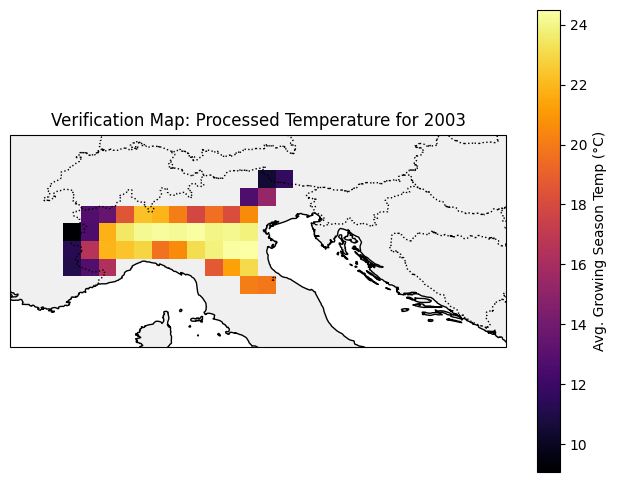

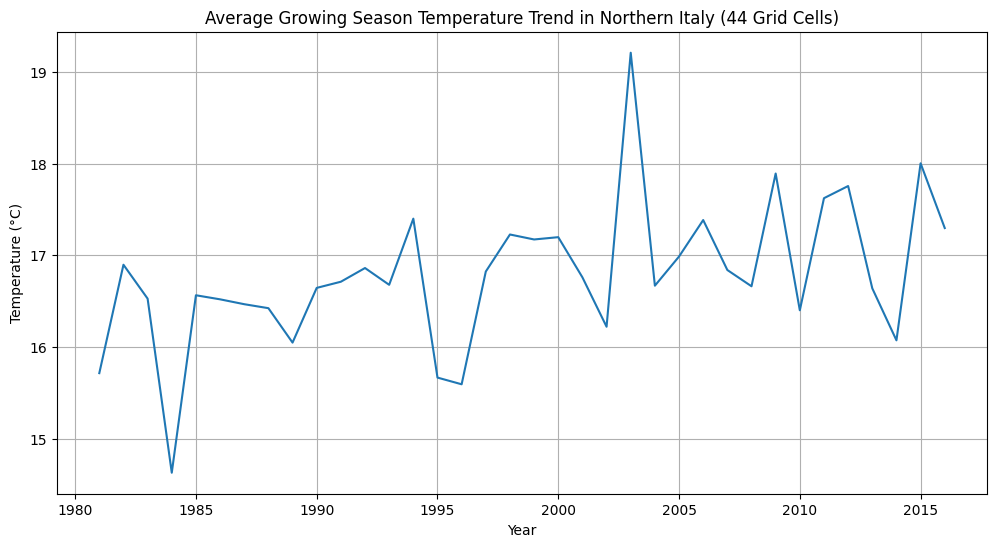

In [5]:
# Cell 4: Visual Verification of Processed Temperature Data (Corrected)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- 1. Visual Verification Map ---
# Let's plot the data for the year 2003, which was a major heatwave year.
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([5, 19, 42, 48], crs=ccrs.PlateCarree()) # Zoom in on N. Italy

ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the temperature data for our region for a single year
regional_temp.sel(year=2003).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='inferno', # A good colormap for temperature
    cbar_kwargs={'label': 'Avg. Growing Season Temp (°C)'}
)
plt.title('Verification Map: Processed Temperature for 2003')
plt.show()


# --- 2. Visual Verification Time-Series ---
# Calculate the average temperature across the 44 cells for each year
mean_temp_trend = regional_temp.mean(dim=['lat', 'lon'])

plt.figure(figsize=(12, 6))
mean_temp_trend.plot()
plt.title('Average Growing Season Temperature Trend in Northern Italy (44 Grid Cells)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

In [7]:
# Final Step (Corrected): Create, Verify, and Save the Unaggregated Dataset
import pandas as pd
import xarray as xr
import os

# --- 1. Combine our two processed xarray DataArrays into a single xarray Dataset ---
# First, we clean the temperature data by dropping the useless GRIB coordinates.
regional_temp_cleaned = regional_temp.drop_vars(['number', 'step', 'surface'], errors='ignore')

# Second, we RENAME the 'year' coordinate in the temperature data to 'time' to match the yield data.
regional_temp_aligned = regional_temp_cleaned.rename({'year': 'time'})

# Now, because the coordinates and dimensions are identical, we can merge them correctly.
final_ds = xr.Dataset({
    'maize_yield': regional_yield,
    'temperature': regional_temp_aligned
})

# --- 2. Convert the Correct 3D Cube to a Long-Format Pandas DataFrame ---
final_df = final_ds.to_dataframe()

# --- 3. Clean up the DataFrame ---
final_df = final_df.dropna().reset_index()
final_df = final_df.rename(columns={'time': 'year'})

# --- 4. Save and Display the Final, Correct Dataset ---
output_dir = '../data/analysis_ready/'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'n_italy_maize_gridcell_temp_data.csv')
final_df.to_csv(output_file, index=False)

print(f"--- Final, Compact Dataset for Northern Italy Maize (Cell by Cell) ---")
print(f"Dataset saved to: {output_file}")
print(f"The table has {len(final_df)} rows (44 cells * 36 years = 1584).")
print("\nHere is the ENTIRE dataset for verification:")

# Set pandas to display all rows, as you requested.
pd.set_option('display.max_rows', None)
print(final_df.to_string())
pd.reset_option('display.max_rows') # Reset display option for future cells

--- Final, Compact Dataset for Northern Italy Maize (Cell by Cell) ---
Dataset saved to: ../data/analysis_ready/n_italy_maize_gridcell_temp_data.csv
The table has 1529 rows (44 cells * 36 years = 1584).

Here is the ENTIRE dataset for verification:
        lon    lat  year  maize_yield  temperature
0      6.75  44.25  1982     4.623395     9.318268
1      6.75  44.25  1983     4.611639     8.809288
2      6.75  44.25  1984     3.952143     7.022491
3      6.75  44.25  1985     5.707234     9.261192
4      6.75  44.25  1986     4.419776     9.255966
5      6.75  44.25  1987     5.979317     9.030014
6      6.75  44.25  1988     5.825632     9.001228
7      6.75  44.25  1989     5.886028     9.011108
8      6.75  44.25  1990     5.129425     9.534920
9      6.75  44.25  1991     6.080171     9.142189
10     6.75  44.25  1992     5.750597     9.178230
11     6.75  44.25  1993     7.243155     9.163452
12     6.75  44.25  1994     7.291387     9.889389
13     6.75  44.25  1995     6.739210